# 1 SETUP
***

In [95]:
# Notebook Config 
import sys
import os
proj_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(proj_root)


# Data Analysis
import pandas as pd
import numpy as np

# DataViz 
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import gridspec

# My Functions
from src.data_prep import DataPreparationPipeline
from src.utils import tab_freq

In [96]:
df_trans = pd.read_csv('../data/raw/train_transaction.csv')
df_id = pd.read_csv('../data/raw/train_identity.csv')

In [97]:
pipeline = DataPreparationPipeline(df_trans,df_id)
df_final = pipeline.feature_selection().df_merge()

# 2 DATA PREPARATION
***

## 2.2 EDA
***

Exploracao para entender quais tratamentos precisam ser realizados e em quais colunas.

In [98]:
df_final.describe().T

,count,mean,std,min,25%,50%,75%,max
card1,590540.0,9.898735e+03,4.901170e+03,1000.000,6.019000e+03,9.678000e+03,1.418400e+04,1.839600e+04
card2,581607.0,3.625555e+02,1.577932e+02,100.000,2.140000e+02,3.610000e+02,5.120000e+02,6.000000e+02
card3,588975.0,1.531949e+02,1.133644e+01,100.000,1.500000e+02,1.500000e+02,1.500000e+02,2.310000e+02
card5,586281.0,1.992789e+02,4.124445e+01,100.000,1.660000e+02,2.260000e+02,2.260000e+02,2.370000e+02
isFraud,590540.0,3.499001e-02,1.837546e-01,0.000,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
TransactionDT,590540.0,7.372311e+06,4.617224e+06,86400.000,3.027058e+06,7.306528e+06,1.124662e+07,1.581113e+07
TransactionAmt,590540.0,1.350272e+02,2.391625e+02,0.251,4.332100e+01,6.876900e+01,1.250000e+02,3.193739e+04
addr1,524834.0,2.907338e+02,1.017411e+02,100.000,2.040000e+02,2.990000e+02,3.300000e+02,5.400000e+02
addr2,524834.0,8.680063e+01,2.690623e+00,10.000,8.700000e+01,8.700000e+01,8.700000e+01,1.020000e+02
dist1,238269.0,1.185022e+02,3.718720e+02,0.000,3.000000e+00,8.000000e+00,2.400000e+01,1.028600e+04


In [99]:

def df_info_completo(df):
    info_df = pd.DataFrame({
        "coluna": df.columns,
        "dtype": df.dtypes.values,
        "nulos": df.isnull().sum().values,
        "% nulos": (df.isnull().sum().values / len(df) * 100).round(2)
    })
    return info_df

info_df = df_info_completo(df_final)
display(info_df.head(50))
display(info_df.tail(27))

,coluna,dtype,nulos,% nulos
0,card1,int64,0,0.00
1,card2,float64,8933,1.51
2,card3,float64,1565,0.27
3,card4,object,1577,0.27
4,card5,float64,4259,0.72
5,card6,object,1571,0.27
6,isFraud,int64,0,0.00
7,TransactionDT,int64,0,0.00
8,TransactionAmt,float64,0,0.00
9,ProductCD,object,0,0.00


,coluna,dtype,nulos,% nulos
49,V188,float64,450721,76.32
50,V194,float64,450721,76.32
51,V221,float64,449124,76.05
52,V242,float64,460110,77.91
53,V247,float64,460110,77.91
54,V250,float64,449124,76.05
55,id_02,float64,449668,76.15
56,id_05,float64,453675,76.82
57,id_06,float64,453675,76.82
58,id_13,float64,463220,78.44


Apesar de todas colunas presentes terem sido selecionadas criteriosamente, será avaliado apenas as que não estão anonimizada.

### 2.2.1 VARIÁVEIS DE CARTÃO
***
Nesta seção, será analisado as variáveis relacionadas aos cartões (card1 a card6) para entender padrões de consistência e ausência de informação.

* card1 será usada como identificação do cliente (granularidade do dataframe).

* card2–card6 serão avaliadas quanto à variabilidade entre transações do mesmo cartão e à ausência de informação, com o objetivo de criar features indicadoras de inconsistência ou falta de dados, que podem sinalizar risco de fraude.

In [100]:
df_card_analysis = df_final[['card1','card2','card3','card4','card5','card6','isFraud']]
df_card_analysis

# Calcular missing por card1 para cada card2–6
missing_dict = {}
for col in ['card2', 'card3', 'card4', 'card5', 'card6']:
    missing_dict[col] = df_card_analysis.groupby('card1')[col].apply(lambda x: x.isna().all())

missing_df = pd.DataFrame(missing_dict).reset_index()

print("Análise individual por variável de cartão:")
for col in ['card2', 'card3', 'card4', 'card5', 'card6']:
    tmp = (
        df_card_analysis.groupby('card1')[col]
        .agg(lambda x: x.nunique(dropna=True))
        .reset_index()
        .rename(columns={col: 'nunique'})
    )
    tmp['varia'] = tmp['nunique'] > 1
    tmp = tmp.merge(
        df_card_analysis[['card1', 'isFraud']].drop_duplicates('card1'),
        on='card1', how='left'
    )
    
    tmp['missing'] = missing_df.set_index('card1')[col].values

    taxa_varia = tmp.loc[tmp['varia'], 'isFraud'].mean()
    taxa_constante = tmp.loc[~tmp['varia'] & ~tmp['missing'], 'isFraud'].mean()
    taxa_missing = tmp.loc[tmp['missing'], 'isFraud'].mean()

    print(f"{col}:")
    print(f"   → Taxa se variou     = {taxa_varia:.3f}")
    print(f"   → Taxa se não variou = {taxa_constante:.3f}")
    print(f"   → Taxa sem informação = {taxa_missing:.3f}\n")

Análise individual por variável de cartão:
card2:
   → Taxa se variou     = 0.020
   → Taxa se não variou = 0.025
   → Taxa sem informação = 0.042

card3:
   → Taxa se variou     = 0.000
   → Taxa se não variou = 0.026
   → Taxa sem informação = 0.100

card4:
   → Taxa se variou     = nan
   → Taxa se não variou = 0.025
   → Taxa sem informação = 0.150

card5:
   → Taxa se variou     = 0.017
   → Taxa se não variou = 0.025
   → Taxa sem informação = 0.092

card6:
   → Taxa se variou     = 0.010
   → Taxa se não variou = 0.026
   → Taxa sem informação = 0.091



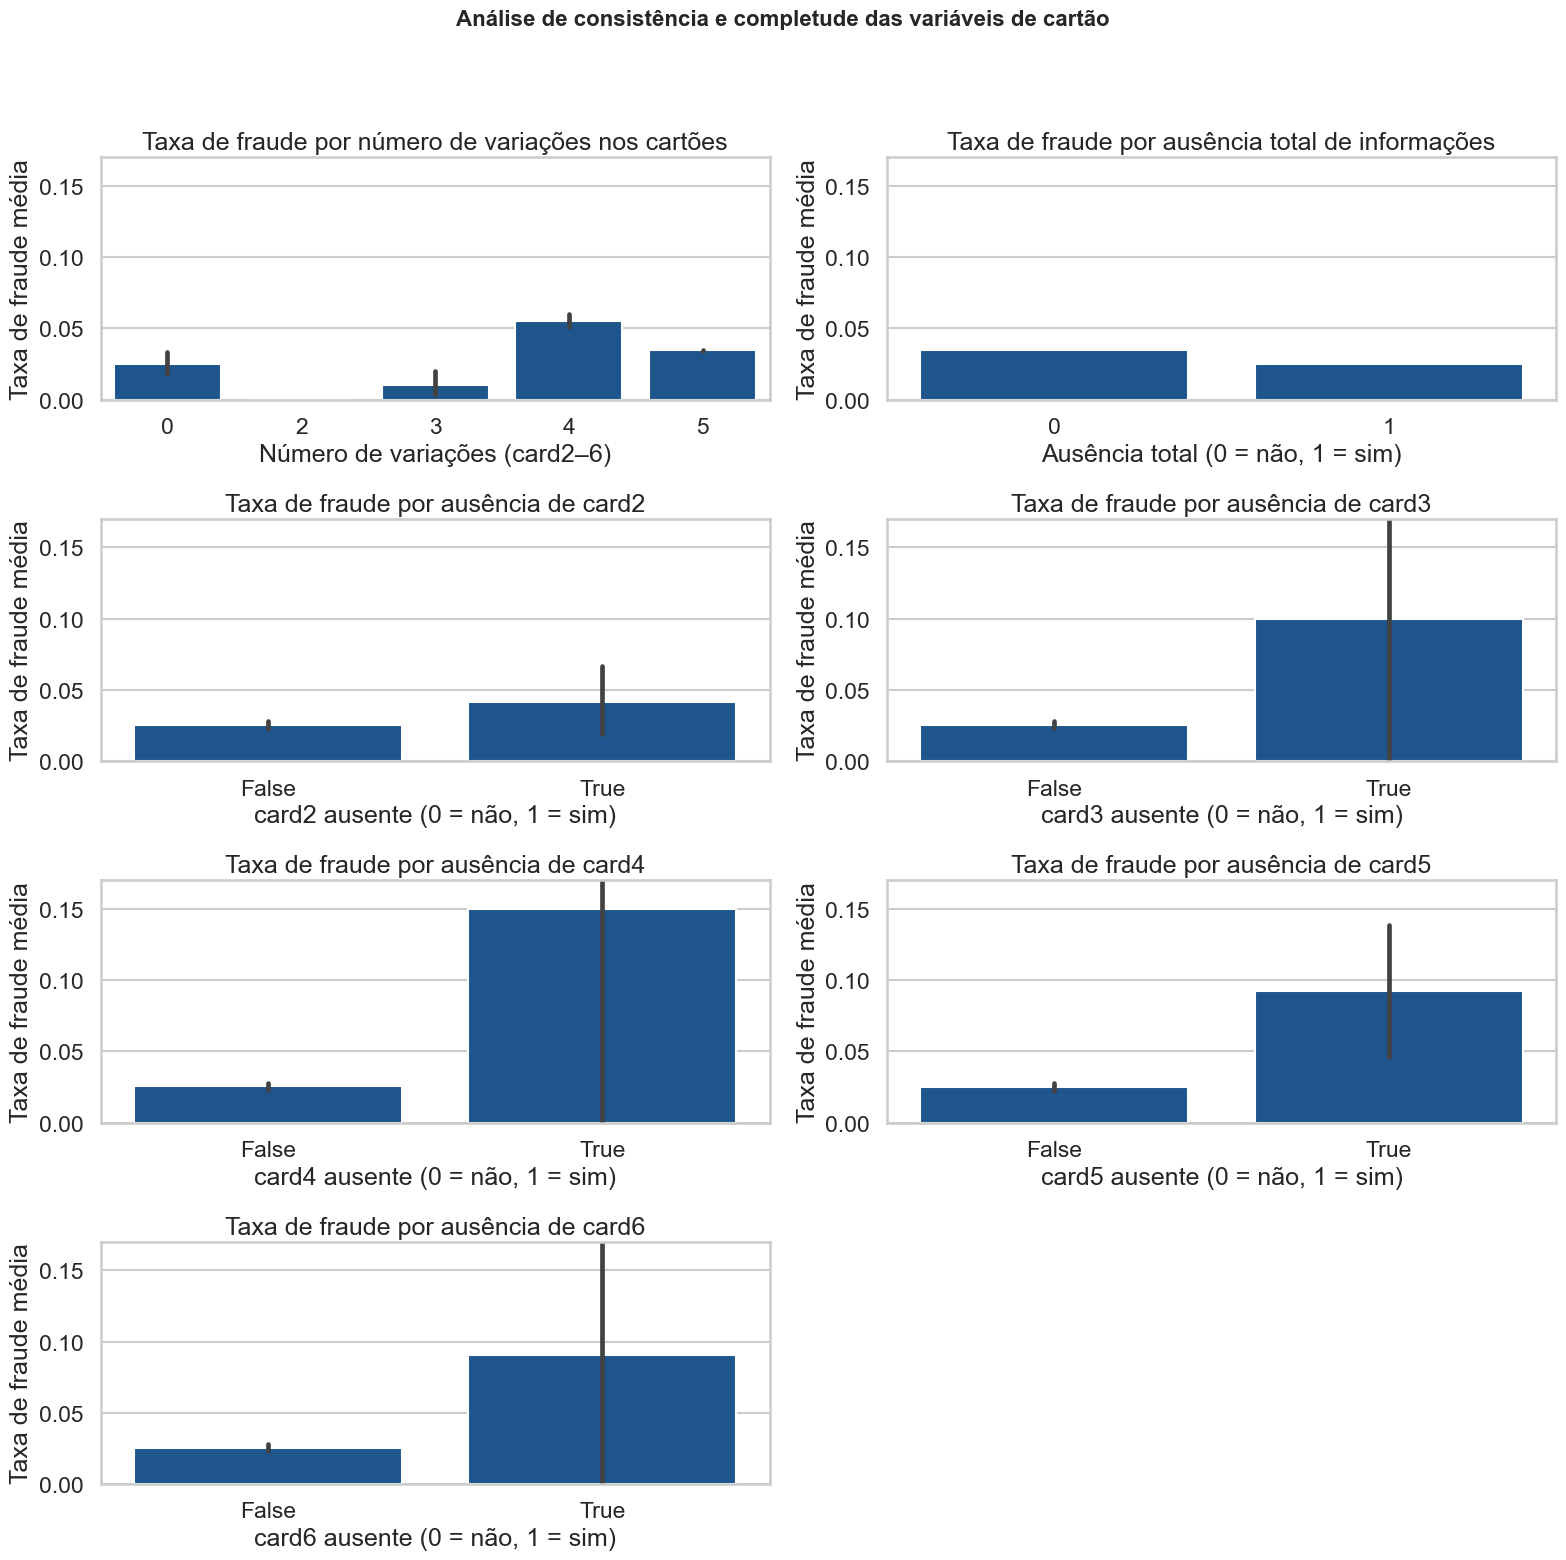

In [101]:

cards = ['card2', 'card3', 'card4', 'card5', 'card6']

df_card_info = df_final.copy()
df_card_info['num_card_diffs'] = df_card_info[cards].nunique(axis=1)
df_card_info['missing_card_info'] = df_card_info[cards].isna().all(axis=1).astype(int)

for col in cards:
    df_card_info[f'{col}_missing'] = df_card_info[col].isna().astype(int)
    
card_summary = {}
for col in cards:
    grouped = df_card_info.groupby(f'{col}_missing')['isFraud'].mean()
    card_summary[col] = {
        'taxa_presente': grouped.get(0, float('nan')),
        'taxa_ausente': grouped.get(1, float('nan'))
    }


sns.set(style="whitegrid", palette="Blues_r", context="talk")

cards = ['card2', 'card3', 'card4', 'card5', 'card6']

fig = plt.figure(figsize=(16, 16))
gs = gridspec.GridSpec(4, 2, figure=fig, height_ratios=[1, 1, 1, 1])
y_max = 0.17

ax0 = fig.add_subplot(gs[0, 0])
sns.barplot(
    x='num_card_diffs',
    y='isFraud',
    data=df_card_info,
    estimator='mean',
    ax=ax0
)
ax0.set_title('Taxa de fraude por número de variações nos cartões')
ax0.set_xlabel('Número de variações (card2–6)')
ax0.set_ylabel('Taxa de fraude média')
ax0.set_ylim(0, y_max)

ax1 = fig.add_subplot(gs[0, 1])
missing_rates = df_card_info.groupby('missing_card_info')['isFraud'].mean().reset_index()
sns.barplot(
    data=missing_rates,
    x='missing_card_info',
    y='isFraud',
    ax=ax1
)
ax1.set_title('Taxa de fraude por ausência total de informações')
ax1.set_xlabel('Ausência total (0 = não, 1 = sim)')
ax1.set_ylabel('Taxa de fraude média')
ax1.set_ylim(0, y_max)

for i, col in enumerate(cards):
    row = 1 + i // 2
    col_idx = i % 2
    if i == 4:  
        ax = fig.add_subplot(gs[3, 0])
    else:
        ax = fig.add_subplot(gs[row, col_idx])
    
    tmp = df_card_analysis.groupby('card1').agg(
        isFraud=('isFraud', 'first'),
        missing=(col, lambda x: x.isna().all())
    ).reset_index()
    
    sns.barplot(
        data=tmp,
        x='missing',
        y='isFraud',
        ax=ax
    )
    ax.set_title(f'Taxa de fraude por ausência de {col}')
    ax.set_xlabel(f'{col} ausente (0 = não, 1 = sim)')
    ax.set_ylabel('Taxa de fraude média')
    ax.set_ylim(0, y_max)

fig.add_subplot(gs[3, 1]).axis('off')

plt.suptitle('Análise de consistência e completude das variáveis de cartão', fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

A taxa de fraude aumenta significativamente quando há ausência de informações (card2 a card6), indicando que campos faltantes podem ser um forte sinal de risco. A variabilidade das informações para o mesmo card1 tem efeito menor sobre a fraude, mudanças nos dados raramente sinalizam fraude por si só. Em análise individual: ausência de dados em card3, card4 e card6 apresenta maior taxa de fraude.

Próximo passo: criar features binárias indicando se cada variável de cartão está ausente ou não, para capturar o risco associado à falta de informação.

### 2.2.2 VARIÁVEIS CATEGORICAS
***
Exploração das variáveis categóricas.

In [102]:
cat_cols = [
    c for c in info_df.iloc[6:,:][info_df['dtype'] == 'object']['coluna'].to_list()
    if not c.startswith("id")
]

cat_cols = ["isFraud"] + cat_cols

df_cat_analysis = df_final[cat_cols].copy()
df_cat_analysis = df_cat_analysis.fillna('missing')
df_cat_analysis

/var/folders/z7/yk0g4q2n7lvbcdw05xr3fljm0000gn/T/ipykernel_1332/3366190795.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  c for c in info_df.iloc[6:,:][info_df['dtype'] == 'object']['coluna'].to_list()


,isFraud,ProductCD,P_emaildomain,R_emaildomain,M1,M2,M3,M4,M5,M6,M7,M8,M9,DeviceType,DeviceInfo
0,0,W,missing,missing,T,T,T,M2,F,T,missing,missing,missing,missing,missing
1,0,W,gmail.com,missing,missing,missing,missing,M0,T,T,missing,missing,missing,missing,missing
2,0,W,outlook.com,missing,T,T,T,M0,F,F,F,F,F,missing,missing
3,0,W,yahoo.com,missing,missing,missing,missing,M0,T,F,missing,missing,missing,missing,missing
4,0,H,gmail.com,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,mobile,SAMSUNG SM-G892A Build/NRD90M
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590535,0,W,missing,missing,T,T,T,M0,T,F,F,F,T,missing,missing
590536,0,W,gmail.com,missing,T,F,F,M0,F,T,F,F,F,missing,missing
590537,0,W,gmail.com,missing,T,F,F,missing,missing,T,missing,missing,missing,missing,missing
590538,0,W,aol.com,missing,T,T,T,M0,F,T,missing,missing,missing,missing,missing


#### PRODUCTCD
***
Categoria do produto/serviço adquirido.

In [103]:
tab_total_productcd = tab_freq(df_cat_analysis, 'ProductCD', 'isFraud')
tab_total_productcd

,ProductCD,pct_total,abs_total,pct_0,pct_1
0,C,11.602770,68519,88.312731,11.687269
1,H,5.592170,33024,95.233769,4.766231
2,R,6.383818,37699,96.217406,3.782594
3,S,1.969045,11628,94.100447,5.899553
4,W,74.452196,439670,97.960061,2.039939


A variável ProductCD apresenta diferenças claras na propensão à fraude. A categoria C apresenta a maior taxa de fraude (11,7%), enquanto W, responsável por mais de 70% das transações, apresenta apenas 2,1% de fraude. Isso indica que certas categorias carregam maior risco relativo, mesmo que sua frequência absoluta seja menor. Para análise e modelagem, a variável será transformada em uma feature contínua representando o risco de fraude associado a cada categoria.

#### P_EMAILDOMAIN & R_EMAILDOMAIN
***
Domínio do e-mail do pagador e recebedor.

##### P_EMAILDOMAIN

In [104]:
tab_total_P_emaildomain = tab_freq(df_cat_analysis, 'P_emaildomain', 'isFraud')
tab_total_P_emaildomain.sort_values(by=['pct_total','pct_1'], ascending=False)

,P_emaildomain,pct_total,abs_total,pct_0,pct_1
16,gmail.com,38.668845,228355,95.645815,4.354185
54,yahoo.com,17.091814,100934,97.724255,2.275745
31,missing,15.994852,94456,97.046244,2.953756
19,hotmail.com,7.662478,45250,94.704972,5.295028
1,anonymous.com,6.265113,36998,97.678253,2.321747
2,aol.com,4.790361,28289,97.818940,2.181060
9,comcast.net,1.335727,7888,96.881339,3.118661
23,icloud.com,1.061232,6267,96.856550,3.143450
36,outlook.com,0.862939,5096,90.541601,9.458399
32,msn.com,0.692925,4092,97.800587,2.199413


##### R_EMAILDOMAIN

In [105]:
tab_total_R_emaildomain = tab_freq(df_cat_analysis, 'R_emaildomain', 'isFraud')
tab_total_R_emaildomain.sort_values(by=['pct_total','pct_1'], ascending=False).head(60)

,R_emaildomain,pct_total,abs_total,pct_0,pct_1
31,missing,76.751617,453249,97.918142,2.081858
16,gmail.com,9.677075,57147,88.081614,11.918386
19,hotmail.com,4.658279,27509,92.220728,7.779272
1,anonymous.com,3.476310,20529,97.087048,2.912952
55,yahoo.com,2.005283,11842,94.848843,5.151157
2,aol.com,0.626715,3701,96.514456,3.485544
36,outlook.com,0.424527,2507,83.486239,16.513761
9,comcast.net,0.306838,1812,98.841060,1.158940
56,yahoo.com.mx,0.255360,1508,98.938992,1.061008
23,icloud.com,0.236732,1398,87.124464,12.875536


##### BIVARIATE ANALYSIS
***

Como existem muitos domínios, e o maior número de fraudes é sobre domínios raros, será realizado algumas análises olhando para o e-mail do pagador e recebedor ao mesmo tempo, para entender se existe algum sinal mais forte de anomalia. 

In [106]:
email_analysis = df_cat_analysis[['P_emaildomain','R_emaildomain','isFraud']].copy()

email_analysis['Same_Email'] = email_analysis['P_emaildomain'] == email_analysis['R_emaildomain']

popular_threshold = 0.01
popular_p = set(email_analysis["P_emaildomain"].value_counts(normalize=True)[lambda x: x >= popular_threshold].index)
popular_r = set(email_analysis["R_emaildomain"].value_counts(normalize=True)[lambda x: x >= popular_threshold].index)

email_analysis["P_email_popular"] = email_analysis["P_emaildomain"].isin(popular_p).astype(int)
email_analysis["R_email_popular"] = email_analysis["R_emaildomain"].isin(popular_r).astype(int)

def consistency_group(row):
    if row["P_email_popular"] and row["R_email_popular"]:
        return 3  # ambos populares
    elif row["P_email_popular"] and not row["R_email_popular"]:
        return 1  # pagador popular, recebedor raro
    elif not row["P_email_popular"] and row["R_email_popular"]:
        return 2  # pagador raro, recebedor popular
    else:
        return 0  # ambos raros
    

email_analysis["email_consistency_group"] = email_analysis.apply(consistency_group, axis=1)


In [107]:
tab_total_same_email= tab_freq(email_analysis, 'Same_Email', 'isFraud')
tab_total_same_email.sort_values(by=['pct_total'], ascending=False)

,Same_Email,pct_total,abs_total,pct_0,pct_1
0,False,68.521015,404644,97.866273,2.133727
1,True,31.478985,185896,93.529178,6.470822


In [108]:
tab_total_consistency_email = tab_freq(email_analysis, 'email_consistency_group', 'isFraud')
tab_total_consistency_email.sort_values(by=['pct_total'], ascending=False)

,email_consistency_group,pct_total,abs_total,pct_0,pct_1
3,3,91.217868,538678,96.485841,3.514159
2,2,5.350696,31598,97.895436,2.104564
0,0,1.778880,10505,93.783912,6.216088
1,1,1.652555,9759,95.747515,4.252485


Para capturar sinais de risco associados aos domínios de email envolvidos nas transações, serão criadas novas variáveis de feature engineering com base na consistência e histórico de fraude dos domínios:

1) email_consistency_group: variável categórica que indica a consistência entre os domínios do pagador e do recebedor. Grupos com combinações comuns e raras de domínios foram classificados de acordo com padrões observados nos dados. Essa variável permite identificar transações potencialmente anômalas quando os domínios não seguem os padrões típicos.

2) missing_p_domain e missing_r_domain: flags binárias indicando ausência de domínio para o pagador ou recebedor. A falta de informação pode ser indicativa de transações suspeitas, uma vez que domínios ausentes tendem a ter maior proporção de fraude.

3) high_risk_p_domain e high_risk_r_domain: flags binárias que sinalizam se o domínio do pagador ou recebedor possui historicamente uma alta taxa de fraude. Para definir “alto risco”, foram considerados domínios com proporção de fraude significativamente maior do que a média, independentemente da popularidade do domínio. Essa abordagem captura o fato de que mesmo domínios amplamente utilizados podem ser explorados por fraudadores, sendo relevante para a detecção de anomalias.

#### M1 - M9
***
Flags de comportamento associadas às transações. 

##### M1

In [109]:
tab_freq_m1 = tab_freq(df_cat_analysis, 'M1', 'isFraud')
tab_freq_m1

,M1,pct_total,abs_total,pct_0,pct_1
0,F,0.004233,25,100.000000,0.000000
1,T,54.088631,319415,98.014495,1.985505
2,missing,45.907136,271100,94.717447,5.282553


##### M2

In [110]:
tab_freq_m2 = tab_freq(df_cat_analysis, 'M2', 'isFraud')
tab_freq_m2

,M2,pct_total,abs_total,pct_0,pct_1
0,F,5.752701,33972,96.514777,3.485223
1,T,48.340163,285468,98.193142,1.806858
2,missing,45.907136,271100,94.717447,5.282553


##### M3

In [111]:
tab_freq_m3 = tab_freq(df_cat_analysis, 'M3', 'isFraud')
tab_freq_m3

,M3,pct_total,abs_total,pct_0,pct_1
0,F,11.465608,67709,96.973814,3.026186
1,T,42.627256,251731,98.294608,1.705392
2,missing,45.907136,271100,94.717447,5.282553


##### M4

In [112]:
tab_freq_m4 = tab_freq(df_cat_analysis, 'M4', 'isFraud')
tab_freq_m4

,M4,pct_total,abs_total,pct_0,pct_1
0,M0,33.258543,196405,96.335124,3.664876
1,M1,8.945372,52826,97.294893,2.705107
2,M2,10.137332,59865,88.626075,11.373925
3,missing,47.658753,281444,98.142792,1.857208


##### M5

In [113]:
tab_freq_m5 = tab_freq(df_cat_analysis, 'M5', 'isFraud')
tab_freq_m5

,M5,pct_total,abs_total,pct_0,pct_1
0,F,22.435567,132491,97.347744,2.652256
1,T,18.215024,107567,96.230256,3.769744
2,missing,59.349409,350482,96.264002,3.735998


##### M6

In [114]:
tab_freq_m6 = tab_freq(df_cat_analysis, 'M6', 'isFraud')
tab_freq_m6

,M6,pct_total,abs_total,pct_0,pct_1
0,F,38.584347,227856,97.631399,2.368601
1,T,32.736817,193324,98.295607,1.704393
2,missing,28.678836,169360,92.931625,7.068375


##### M7
***

In [115]:
tab_freq_m7 = tab_freq(df_cat_analysis, 'M7', 'isFraud')
tab_freq_m7

,M7,pct_total,abs_total,pct_0,pct_1
0,F,35.793342,211374,98.065514,1.934486
1,T,5.571341,32901,97.787301,2.212699
2,missing,58.635317,346265,95.423736,4.576264


##### M8
***

In [116]:
tab_freq_m8 = tab_freq(df_cat_analysis, 'M8', 'isFraud')
tab_freq_m8

,M8,pct_total,abs_total,pct_0,pct_1
0,F,26.289667,155251,97.827389,2.172611
1,T,15.077217,89037,98.378202,1.621798
2,missing,58.633115,346252,95.423564,4.576436


##### M9
***

In [117]:
tab_freq_m9 = tab_freq(df_cat_analysis, 'M9', 'isFraud')
tab_freq_m9

,M9,pct_total,abs_total,pct_0,pct_1
0,F,6.541809,38632,96.999896,3.000104
1,T,34.825075,205656,98.221302,1.778698
2,missing,58.633115,346252,95.423564,4.576436


Com exceção da variável M5, cujas categorias não apresentaram diferenças significativas na proporção de fraudes, as demais variáveis categóricas serão substituidas cada categoria pela sua taxa de ocorrência de fraude no conjunto de dados. Essa abordagem visa representar o risco histórico associado a cada categoria.

#### DeviceType e DeviceInfo
***

##### DeviceType
***

In [118]:
tab_freq_dt = tab_freq(df_cat_analysis, 'DeviceType', 'isFraud')
tab_freq_dt

,DeviceType,pct_total,abs_total,pct_0,pct_1
0,desktop,14.421546,85165,93.478542,6.521458
1,missing,76.155722,449730,97.898295,2.101705
2,mobile,9.422732,55645,89.833768,10.166232


##### DeviceInfo
***

In [119]:
tab_freq_di = tab_freq(df_cat_analysis, 'DeviceInfo', 'isFraud')
tab_freq_di.sort_values(by='pct_total', ascending=False).head(50)

,DeviceInfo,pct_total,abs_total,pct_0,pct_1
1735,missing,79.905510,471874,97.445081,2.554919
1598,Windows,8.081078,47722,93.460039,6.539961
1727,iOS Device,3.349815,19782,93.731675,6.268325
723,MacOS,2.129068,12573,97.788913,2.211087
1552,Trident/7.0,1.259864,7440,98.709677,1.290323
1744,rv:11.0,0.321909,1901,96.002104,3.997896
1770,rv:57.0,0.162902,962,89.293139,10.706861
1360,SM-J700M Build/MMB29K,0.092966,549,89.071038,10.928962
1199,SM-G610M Build/MMB29K,0.078064,461,91.973970,8.026030
1189,SM-G531H Build/LMY48B,0.069428,410,91.951220,8.048780


Embora as variáveis device_info e device_type apresentem leves diferenças de risco entre categorias (por exemplo, mobile e desktop com ligeiro aumento na taxa de fraude), essas diferenças não parecem refletir um padrão causal consistente. Considerando que o tipo de dispositivo não é, por si só, determinante para a ocorrência de fraudes e que seu sinal pode estar mais associado a ruído do que a informação relevante, optou-se por excluir essas variáveis do modelo a fim de evitar complexidade desnecessária e reduzir a dimensionalidade.

### 2.2.3 VARIÁVEIS NUMÉRICAS & DATA
***
Exploração das variáveis numéricas e de data.

In [120]:
num_cols = [
    c for c in info_df.iloc[6:,:][info_df['dtype'] != 'object']['coluna'].to_list()
    if not c.startswith("id")
]

#num_cols = ["isFraud"] + num_cols

df_num_analysis = df_final[num_cols].copy()
#df_num_analysis = df_num_analysis.fillna())
df_num_analysis

/var/folders/z7/yk0g4q2n7lvbcdw05xr3fljm0000gn/T/ipykernel_1332/2299904362.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  c for c in info_df.iloc[6:,:][info_df['dtype'] != 'object']['coluna'].to_list()


,isFraud,TransactionDT,TransactionAmt,addr1,addr2,dist1,dist2,C1,C5,D2,...,V86,V148,V167,V170,V188,V194,V221,V242,V247,V250
0,0,86400,68.50,315.0,87.0,19.0,NaN,1.0,0.0,NaN,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,86401,29.00,325.0,87.0,NaN,NaN,1.0,0.0,NaN,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,86469,59.00,330.0,87.0,287.0,NaN,1.0,0.0,NaN,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,86499,50.00,476.0,87.0,NaN,NaN,2.0,0.0,112.0,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,86506,50.00,420.0,87.0,NaN,NaN,1.0,0.0,NaN,...,NaN,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590535,0,15811047,49.00,272.0,87.0,48.0,NaN,2.0,1.0,29.0,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
590536,0,15811049,39.50,204.0,87.0,NaN,NaN,1.0,0.0,NaN,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
590537,0,15811079,30.95,231.0,87.0,NaN,NaN,1.0,1.0,NaN,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
590538,0,15811088,117.00,387.0,87.0,3.0,NaN,1.0,0.0,22.0,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### DATA
***
Nesta seção, será explorado o comportamento temporal das transações, em especial:
- Padrões de ocorrência de fraudes por hora do dia;
- Identificação de horários atípicos;
- Transformações cíclicas para representação adequada do tempo.


In [121]:
df_final.drop(columns=['V4', 'V12', 'V19', 'V23', 'V37', 'V44', 'V46', 'V53', 'V56', 'V61',
       'V66', 'V77', 'V86', 'V148', 'V167', 'V170', 'V188', 'V194', 'V221',
       'V242', 'V247', 'V250', 'id_02', 'id_05', 'id_06', 'id_13', 'id_14',
       'id_15', 'id_18', 'id_19', 'id_20', 'id_28', 'id_29', 'id_30', 'id_31',
       'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType',
       'DeviceInfo'], inplace=True)

In [122]:
df_final['TransactionDT2'] = pd.to_timedelta(df_final['TransactionDT'], unit='s')

date_components = df_final['TransactionDT2'].dt.components.iloc[:,:4]

date_components['hour_fractional'] = (
    date_components['hours'] +
    date_components['minutes'] / 60 +
    date_components['seconds'] / 3600
)

df_final = df_final.assign(day = date_components['days'],
                hour = date_components['hours'],
                minute = date_components['minutes'],
                second = date_components['seconds'],
                hour_fractional = date_components['hour_fractional']
                )



/var/folders/z7/yk0g4q2n7lvbcdw05xr3fljm0000gn/T/ipykernel_1332/2486769373.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


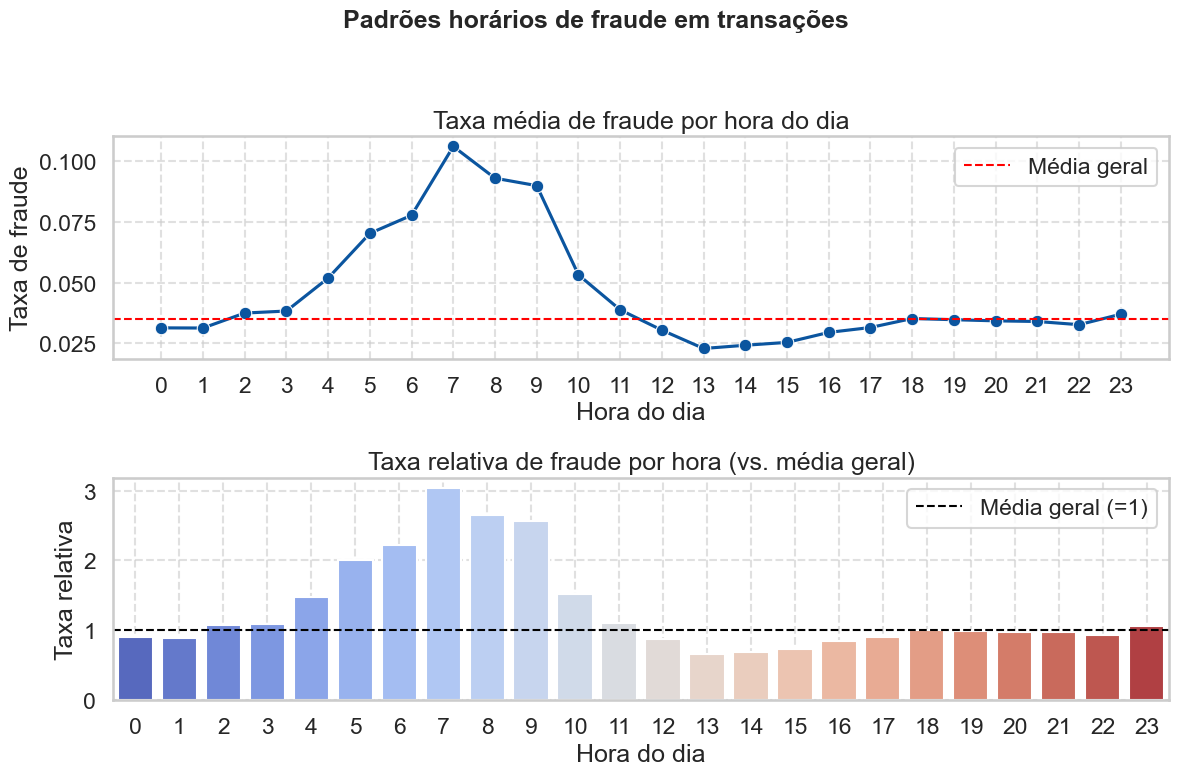

In [134]:
hourly_fraud = (
    df_final.groupby('hour')['isFraud']
    .agg(fraud_rate='mean', count='size')
    .reset_index()
)

overall_rate = df_final['isFraud'].mean()
hourly_fraud['relative_rate'] = hourly_fraud['fraud_rate'] / overall_rate


sns.set(style="whitegrid", palette="Blues_r", context="talk")

fig, axes = plt.subplots(2, 1, figsize=(12, 8))

sns.lineplot(
    data=hourly_fraud,
    x='hour',
    y='fraud_rate',
    marker='o',
    ax=axes[0]
)
axes[0].axhline(overall_rate, color='red', linestyle='--', linewidth=1.5, label='Média geral')
axes[0].set_title('Taxa média de fraude por hora do dia')
axes[0].set_xlabel('Hora do dia')
axes[0].set_ylabel('Taxa de fraude')
axes[0].set_xticks(range(24))
axes[0].legend()
axes[0].grid(True, linestyle='--', alpha=0.6)

sns.barplot(
    data=hourly_fraud,
    x='hour',
    y='relative_rate',
    ax=axes[1],
    palette="coolwarm"
)
axes[1].axhline(1, color='black', linestyle='--', linewidth=1.5, label='Média geral (=1)')
axes[1].set_title('Taxa relativa de fraude por hora (vs. média geral)')
axes[1].set_xlabel('Hora do dia')
axes[1].set_ylabel('Taxa relativa')
axes[1].legend()
axes[1].grid(True, linestyle='--', alpha=0.6)

plt.suptitle('Padrões horários de fraude em transações', fontsize=18, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

O gráfico por hora mostra que a taxa de fraude e fraude relativa à média geral (relative_rate) é mais alta em horários incomuns, especialmente entre 4h e 9h, indicando períodos potencialmente suspeitos para transações. Para o relative_rate valores acima de 1 indicam risco acima da média, enquanto valores abaixo de 1 indicam risco menor.

##### TRANSFORMACOES SENO E COSSENO
***

A transformação seno/cosseno permite representar variáveis cíclicas (hora, dia da semana) preservando a continuidade. Isso evita que o modelo interprete 23h e 0h como distantes, possibilitando detecção correta de padrões e anomalias ao longo do tempo.

In [124]:
df_final['hour_sin'] = np.sin(2 * np.pi * df_final['hour_fractional'] / 24)
df_final['hour_cos'] = np.cos(2 * np.pi * df_final['hour_fractional'] / 24)

#### TRANSACTIONAMT
***

Análise descritiva da variável `TransactionAmt`

count    590540.000000
mean        135.027176
std         239.162522
min           0.251000
1%            9.244000
5%           20.000000
25%          43.321000
50%          68.769000
75%         125.000000
95%         445.000000
99%        1104.000000
max       31937.391000
Name: TransactionAmt, dtype: float64


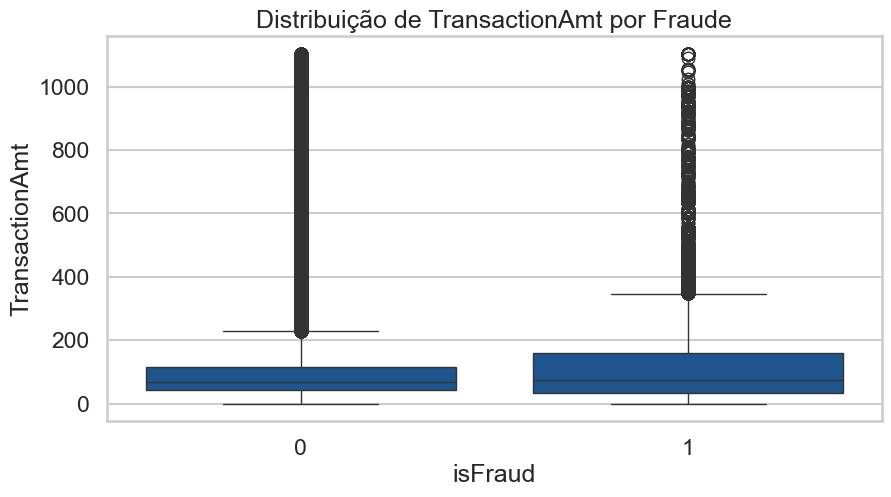

In [ ]:
sns.set(style="whitegrid", context="talk", palette="Blues_r")

tx_stats = df_final['TransactionAmt'].describe(percentiles=[0.01,0.05,0.25,0.5,0.75,0.95,0.99])
print(tx_stats)

# Boxplot
max_val = df_final['TransactionAmt'].quantile(0.99)
plt.figure(figsize=(10,5))
sns.boxplot(x='isFraud', y='TransactionAmt', data=df_final[df_final['TransactionAmt'] <= max_val])
plt.title('Distribuição de TransactionAmt por Fraude')
plt.show()

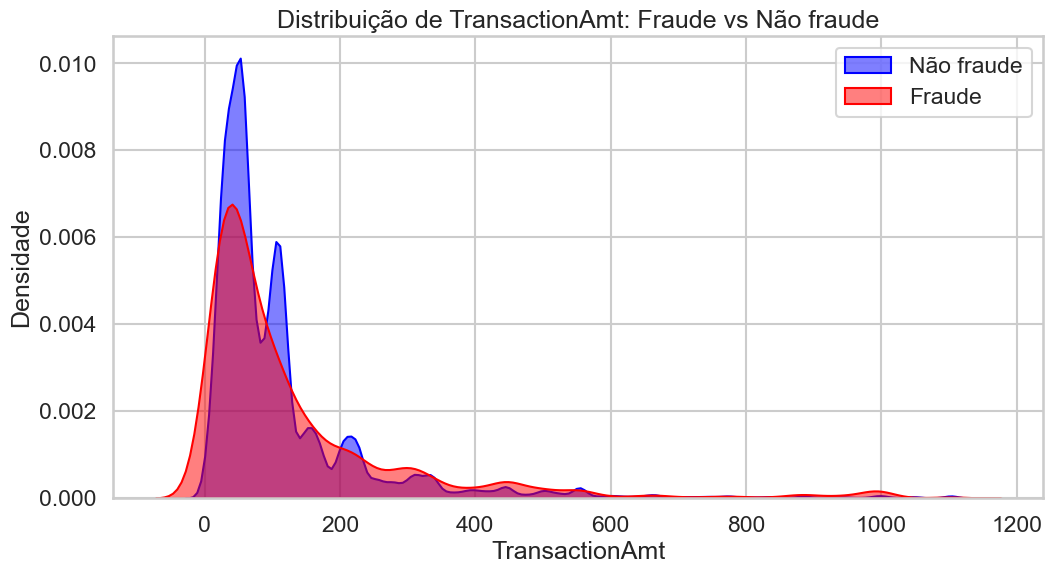

In [156]:
plt.figure(figsize=(12,6))

sns.kdeplot(
    df_final[df_final['TransactionAmt'] <= max_val].loc[df_final['isFraud']==0, 'TransactionAmt'], 
    fill=True, alpha=0.5, label='Não fraude', color='blue'
)
sns.kdeplot(
    df_final[df_final['TransactionAmt'] <= max_val].loc[df_final['isFraud']==1, 'TransactionAmt'], 
    fill=True, alpha=0.5, label='Fraude', color='red'
)

plt.xlabel('TransactionAmt')
plt.ylabel('Densidade')
plt.title('Distribuição de TransactionAmt: Fraude vs Não fraude')
plt.legend()
plt.show()

A análise da densidade das transações fraudulentas e legítimas mostra que ambas seguem distribuições muito semelhantes. Ou seja, não há uma faixa de valores claramente distinta que diferencie transações fraudulentas das não fraudulentas. Isso indica que o valor isolado da transação não é um forte discriminador de fraude, embora possa ser usado em combinação com outras variáveis ou em features derivadas (como agregações por períodos de tempo ou variações entre transações consecutivas).

TO DO 

FAZER A EXPLORACAO DAS VARIAVEIS DE TEMPO 

VER COMO CRIAR NOVAS VARIAVEIS (DIA, HORA DA TRANSACAO)
ANALISAR QUAL A MELHOR JANELA PARA CRIAR AS VARIAVEIS NUMERICAS (ULTIMOS 7, 30, 60 dias?)
ANALISAR VARIAVEIS NUMÉRICAS COM IDENTIFICACAO

IR PARA MODELAGEM PRA RESPONDER AS PERGUNTAS DO PROFESSOR